# Introduction
Mobile Apps has been increasingly popular for people to share instant feelings, emotions, opinions,
stories, and so on. As a leading food delivery platform, Yemeksepeti has gained tremendous popularity
since its inception. People comment on the comments section of the restaurants which they
order meal to spread goodness or badness of the restaurant. Therefore, enough data is generated
for sentiment analysis to give an intuition to people who are seeking delicious food. The comments
are not clean. That means we will start with the data cleaning, and continue with the changing
dataset in order to make it useful for our purpose. Word2Vec, CNN and Bidirectional LSTM will
be used and explained later.

#### *I hope this notebook will give you an intuition about data handling by purpose and creating different type of training models* 

* I tried to keep it as simple as possible. Have a nice ml day.
> If you find my work useful please don't forget to *Upvote!* so it can reach more people.

In [39]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# nltk
import nltk
from nltk.corpus import stopwords

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Choosing language dependent stemmer is important before cleaning the text.

In [40]:
nltk.download('stopwords')
!pip install TurkishStemmer
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Settings

Dataset is big enough to take only %10 of the train set as test set so we will use our most of the data as our training set. Most of the parameters are chosen by experience and lots of tries. However, you can improve them as you wish.

In [148]:
TEST_SIZE = 0.1

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

## Read Dataset

### Dataset details
The dataset was created by Doğukan Arslan from Turkish restaurant reviews taken from the
food ordering site [yemeksepeti.com](https://https://www.yemeksepeti.com). The dataset also includes scores in speed, service and flavour categories. In this respect, it is expected to be used in aspect-based sentiment analysis studies. Therefore, for sentiment extraction, dataset named [Yorumsepeti](https://www.kaggle.com/dgknrsln/yorumsepeti) choice is reasonable and challenging.
* **speed**: speed point
* **service**: service point
* **flavour**: flavour point
* **review**: the text of the comments (Superdi.)
* **target**: the polarity of the tweet (1-5 = negative, 6-10 = positive) -> custom feature, we created target feature to be able to make binary classification | negative will be added as threshold |


In [42]:
df= pd.read_csv("../input/yorumsepeti/yorumsepeti.csv", sep=';')

In [43]:
print("Dataset size:", len(df))

Dataset size: 60242


In [44]:
df.head(5)

,speed,service,flavour,review
0,-,1,1,Her zaman komşu fırından sipariş verdiğim için...
1,-,10,2,sosisli ürün isteyen adama peynirli bişey yol...
2,-,10,10,Siparisimi cok hizli getiren ekip arkadasiniza...
3,1,1,7,"After waiting more tjan one hour, they didnt d..."
4,4,4,1,Iyi pişsin diye söylememe rağmen az pişmiş gel...


In [45]:
df['Character Count'] = df['review'].apply(lambda x: len(str(x)))
df['Character Count'].max(axis = 0, skipna = True)

310

In [46]:
pd.isna(df['review']).sum()

33

# Pre-Process dataset

As explained before dataset includes 3 features labelled as speed, service and flavour out of 10
points. For sentiment analysis, it is difficult to reach state-of-art results by using 10 classes for
every point due to lack of size of dataset. Therefore, as pre-processing step, the ’-’ character is
deleted from the dataset and inserted NaN instead. This is done because, for every row, we will
take the mean of 3 features and create new column as target to hold rounded mean scores(int).
Meanwhile, dataset has NaN values for reviews which mean that we cannot use those rows for any
sentiment analysis. Therefore, we will drop NULL review rows. In raw dataset, 33 rows has no
reviews, and the latest dataset size is 60206 rows.

In [47]:
df = df.dropna(subset=['review'], axis=0)

In [48]:
# We will use the mean of 3 point scoring system
# so we will change the dataset to target-text

df['speed'] = df['speed'].replace(['-'], np.nan)
df['service'] = df['service'].replace(['-'], np.nan)
df['flavour'] = df['flavour'].replace(['-'], np.nan)

df['speed'] = df['speed'].astype(float)
df['service'] = df['service'].astype(float)
df['flavour'] = df['flavour'].astype(float)
df['review'] = df['review'].astype(str)


## Creating a target column to be able to make binary classification depending on mean of 3 types of scoring

In [49]:
df = df.assign(target=df.loc[:, ['speed', 'service', 'flavour']].mean(axis=1))
df['target'] = round(df['target'])

df = df.dropna(subset=['target'], axis=0)
df['target'] = df['target'].astype(int)

df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,1
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,6
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,10
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,3
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,3
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,10
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,10
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,10
60240,10.0,10.0,10.0,Harikasınız!,12,10


### Recap: We have mean scores in target column. We map it as, 1-5 points correspond to negative, 6-10 points correspond to positive. We will use 0.4-0.7 as thresholds for neutral addition in the last section.

In [50]:
decode_map = { 1:"NEGATIVE", 2:"NEGATIVE" ,3: "NEGATIVE", 4:"NEGATIVE", 5:"NEGATIVE",6: "POSITIVE",
              7: "POSITIVE", 8: "POSITIVE", 9: "POSITIVE", 10: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [51]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 29.7 ms


In [52]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,POSITIVE
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,NEGATIVE
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,POSITIVE
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,POSITIVE
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,POSITIVE
60240,10.0,10.0,10.0,Harikasınız!,12,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

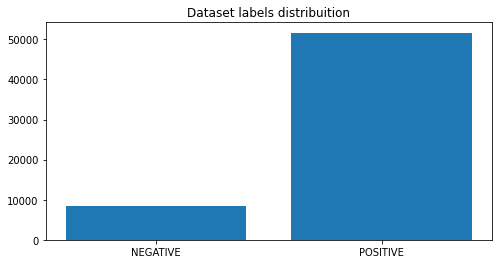

In [53]:
target_cnt = Counter(df.target)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [54]:
stop_words = stopwords.words("turkish")

In [55]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [56]:
%%time
df.review = df.review.apply(lambda x: preprocess(x))

CPU times: user 1.54 s, sys: 8.53 ms, total: 1.55 s
Wall time: 1.57 s


In [57]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,zaman komşu fırından sipariş verdiğim eksik gö...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yoll...,135,POSITIVE
2,NaN,10.0,10.0,siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,after waiting more tjan one hour they didnt de...,85,NEGATIVE
4,4.0,4.0,1.0,iyi pişsin söylememe rağmen pişmiş geldi birda...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,super,6,POSITIVE
60238,10.0,10.0,10.0,mükemmelsiniz,14,POSITIVE
60239,10.0,10.0,10.0,çorbası efsane mutlaka deneyin,31,POSITIVE
60240,10.0,10.0,10.0,harikasınız,12,POSITIVE


## Split train and test

In [58]:
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 54185
TEST size: 6021


## Word2Vec 

In [59]:
%%time
documents = [_text.split() for _text in df_train.review] 

CPU times: user 123 ms, sys: 46.6 ms, total: 169 ms
Wall time: 191 ms


In [60]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [61]:
w2v_model.build_vocab(documents)

In [62]:
vocab_len = len(w2v_model.wv)
print("Vocab size", vocab_len)

Vocab size 4775


In [63]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 32.9 s, sys: 213 ms, total: 33.1 s
Wall time: 17.5 s


(5896026, 8096368)

In [64]:
w2v_model.wv.most_similar("tatlı")

[('hediye', 0.6936839818954468),
 ('kurabiye', 0.6768707036972046),
 ('puding', 0.6748520731925964),
 ('göndermeleri', 0.6657190918922424),
 ('gönderdikleri', 0.6464883685112),
 ('ikramı', 0.6393988728523254),
 ('tatlısı', 0.6292093396186829),
 ('tatlılar', 0.6156030297279358),
 ('tatlıyı', 0.6124419569969177),
 ('gönderdiğiniz', 0.6091635823249817)]

In [65]:
all_sims = w2v_model.wv.most_similar(negative="tatlı")
all_sims

[('yavaş', 0.4529588222503662),
 ('lahmacunlar', 0.4214540719985962),
 ('yağlı', 0.3820110857486725),
 ('ürünler', 0.3720821142196655),
 ('paketlemesi', 0.3689930737018585),
 ('sunum', 0.3563849627971649),
 ('bulmadım', 0.354972243309021),
 ('soğuktu', 0.35295942425727844),
 ('beklediğimden', 0.35217413306236267),
 ('paketlenmişti', 0.3463815152645111)]

## Tokenize Text

In [66]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 46043
CPU times: user 1.33 s, sys: 94.9 ms, total: 1.43 s
Wall time: 1.32 s


In [67]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review), maxlen=SEQUENCE_LENGTH)

CPU times: user 1.82 s, sys: 47.8 ms, total: 1.87 s
Wall time: 1.87 s


In [68]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [69]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (54185, 300)
y_train (54185, 1)

x_test (6021, 300)
y_test (6021, 1)


____________________________________

# Imbalanced distribution handling

SMOTE [1](https://arxiv.org/abs/1106.1813) (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. SMOTE synthesises new minority instances
between existing minority instances. It generates the virtual training records by linear interpolation
for the minority class. These synthetic training records are generated by randomly selecting
one or more of the k-nearest neighbors for each example in the minority class. After the oversampling
process, the data is reconstructed and several classification models can be applied for the
processed data. We had 1: 46502, 0: 7683 distribution in training set. After SMOTE it becomes
to 0: 46502, 1: 46502.

In [70]:
from imblearn.over_sampling import SMOTE

def smote(x, y):
    smote = SMOTE(sampling_strategy= 1, random_state=42)
    x, y = smote.fit_resample(x, y)
    return x, y

In [71]:
print(x_train.shape)
print(y_train.shape)

(54185, 300)
(54185, 1)


In [72]:
# CREATING DICTIONARY TO SEE CLASS DIST
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{1: 46502, 0: 7683}

In [73]:
x_train, y_train = smote(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(93004, 300)
(93004,)


In [74]:
## CONTROL THE AUGMENTED DISTRIBUTION
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{0: 46502, 1: 46502}

## Embedding layer

In [75]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(46043, 300)


# Build Model
Word2Vec-CNN-BiLSTM-FC learning pipeline, which consists of four sequential module.
Recently, Word2Vec model still produces competitive results by using as embedding matrix of
deep learning models.<br /><br />
The combination of CNN and BiLSTM models requires a particular design, since each model
has a specific architecture and its own strengths:<br />
• BERT is utilized to transform word tokens from the raw Tweet messages to contextual word
embeddings.<br />
• CNN is known for its ability to extract as many features as possible from the text.<br />
• BiLSTM keeps the chronological order between words in a document, thus it has the ability
to ignore unnecessary words using the delete gate.<br />
• Fully Connected Layers give robustness to decrease unsteadiness of results in hard cases.<br />
The purpose of combining these two models is to create a model that takes advantage of the
strengths of CNN and BiLSTM, so that it captures the features extracted using CNN, and uses
them as an LSTM input. Therefore, I develop a model that meets this objective, such that the
vectors built in the word embedding part are used as convolutional neural network input.

In [76]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                                            input_length=SEQUENCE_LENGTH, trainable=False)

sequence_input = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = tf.keras.layers.SpatialDropout1D(0.2)(embedding_sequences)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          13812900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 64)           57664     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

## Compile model

In [77]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Callbacks

In [78]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# Train

In [79]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/3
327/327 [==============================] - 941s 3s/step - loss: 0.3440 - accuracy: 0.8427 - val_loss: 0.2491 - val_accuracy: 0.8986
Epoch 2/3
327/327 [==============================] - 941s 3s/step - loss: 0.2469 - accuracy: 0.8919 - val_loss: 0.1312 - val_accuracy: 0.9562
Epoch 3/3
327/327 [==============================] - 943s 3s/step - loss: 0.2238 - accuracy: 0.9036 - val_loss: 0.1548 - val_accuracy: 0.9369
CPU times: user 1h 13min 26s, sys: 8min 51s, total: 1h 22min 17s
Wall time: 47min 26s


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Evaluate

In [80]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

24/24 [==============================] - 4s 157ms/step - loss: 0.2439 - accuracy: 0.8876

ACCURACY: 0.8875601887702942
LOSS: 0.24389003217220306
CPU times: user 4.27 s, sys: 14.8 ms, total: 4.29 s
Wall time: 5.58 s


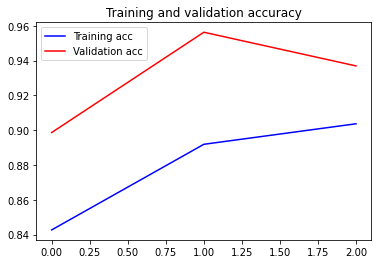

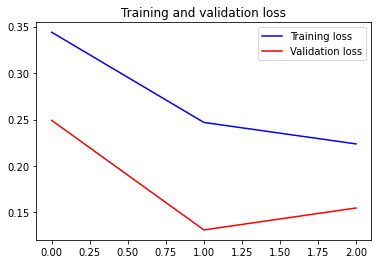

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [143]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [144]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [84]:
predict("Lütfen şu yemeği düzgün pişirin")

{'label': 'NEGATIVE',
 'score': 0.33940690755844116,
 'elapsed_time': 1.061476707458496}

In [85]:
predict("İşini aşkla yapan bir mekan daha sarrrrdı")

{'label': 'POSITIVE',
 'score': 0.9351643919944763,
 'elapsed_time': 0.20290398597717285}

In [86]:
predict("Kuryeniz çok saygısız")

{'label': 'POSITIVE',
 'score': 0.6826003193855286,
 'elapsed_time': 0.20383787155151367}

In [87]:
predict("lezzet sıfır kalite sıfır hizmet sıfır ekmek arası ekmek de göndermezsiniz.")

{'label': 'NEGATIVE',
 'score': 0.16594374179840088,
 'elapsed_time': 0.20233631134033203}

In [88]:
predict("EFFFFSANEYDİ BEEE")

{'label': 'POSITIVE',
 'score': 0.8282578587532043,
 'elapsed_time': 0.20007967948913574}

In [89]:
predict("Ellerinize sağlık çok güzeldi")

{'label': 'POSITIVE',
 'score': 0.9994027614593506,
 'elapsed_time': 0.20487356185913086}

In [90]:
predict("Bi tantuni yiyelim dedik kusacaktık reziller sizi")

{'label': 'NEGATIVE',
 'score': 0.46885398030281067,
 'elapsed_time': 0.20421195030212402}

In [91]:
predict("Hep buradan alıyoruz yine memnunuz teşekkürler")

{'label': 'POSITIVE',
 'score': 0.9847643971443176,
 'elapsed_time': 0.1996603012084961}

In [92]:
predict("bir daha burdan almayın paranıza yazık")

{'label': 'NEGATIVE',
 'score': 0.15647052228450775,
 'elapsed_time': 0.20186638832092285}

In [93]:
predict("Bugün günlerden açlık günü zannetmiştim ama varya biliyosunuz bu işi.")

{'label': 'POSITIVE',
 'score': 0.6990450620651245,
 'elapsed_time': 0.2032938003540039}

## Confusion Matrix

In [94]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 780ms/step
CPU times: user 817 ms, sys: 34.5 ms, total: 851 ms
Wall time: 845 ms


In [95]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

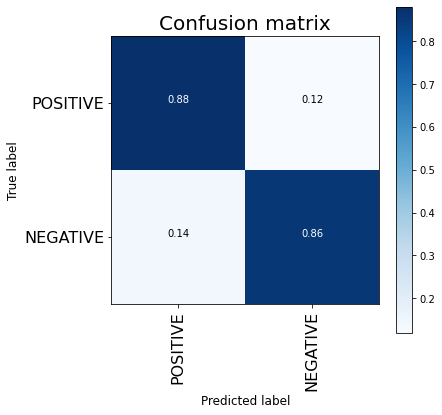

CPU times: user 307 ms, sys: 96.7 ms, total: 404 ms
Wall time: 269 ms


In [96]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

## Classification Report

In [97]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.51      0.88      0.65       867
    POSITIVE       0.98      0.86      0.91      5154

    accuracy                           0.86      6021
   macro avg       0.75      0.87      0.78      6021
weighted avg       0.91      0.86      0.88      6021



## Accuracy Score

In [98]:
accuracy_score(y_test_1d, y_pred_1d)

0.8623152300282345

# Save model

In [99]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

_____
# After you've prepared your model, do not need to train everytime.

In [100]:
with open('../input/models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

with open('../input/models/encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

w2v_model = gensim.models.word2vec.Word2Vec.load("../input/models/model.w2v")
model = tf.keras.models.load_model('../input/model/model.h5')

_________
### In next step, we will use our prepared model to predict yemeksepeti comments on twitter using Twint.

# Fetching data from twitter
To get started,

* Import the twint package as follows.

In [133]:
!pip install twint
import twint
import nest_asyncio
nest_asyncio.apply()
!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

  Cloning https://github.com/twintproject/twint.git (to revision origin/master) to /tmp/pip-install-pdkb9rw_/twint_2978645249f94220aeb46d690a61d928
  Running command git clone --filter=blob:none -q https://github.com/twintproject/twint.git /tmp/pip-install-pdkb9rw_/twint_2978645249f94220aeb46d690a61d928
  Running command git checkout -q origin/master
  Resolved https://github.com/twintproject/twint.git to commit origin/master
  Preparing metadata (setup.py) ... done


In [136]:
c = twint.Config()
c.Search = "getirYemek" #keyword for search
c.Limit = 100 #limit of the number of tweets which will be extracted
c.Store_csv = True 
c.Output = 'GetirYemek_tweet_data.csv'
twint.run.Search(c)

1473949419888279552 2021-12-23 09:31:41 +0000 <StarbucksTR> @MehmetK96492336 Merhaba, eve servis hizmetlerimiz Yemeksepeti ve Getiryemek üzerinden verilmektedir. 😊
1473896624514641922 2021-12-23 06:01:53 +0000 <GetirYemek> @nrimumponnocere Merhaba, yardımcı olabilmemiz için telefon numaranızı DM yoluyla iletebilir misiniz?
1473893748685918217 2021-12-23 05:50:27 +0000 <Jale_TC> @GetirYemek @getir @GetirCarsi @getirbuyuk Yardımcı olmuyorsunuz ki. 2 gün boyunca sizi arayan sizinde tamam geliyor firma gönderiyor demek için aradığınız numara zaten sisteminizde kayıtlı. Buralardan boşuna yazmayın yani çözüm bulun bir zahmet
1473891427755118599 2021-12-23 05:41:14 +0000 <GetirYemek> @Jale_TC @getir @GetirCarsi @getirbuyuk Merhaba, yardımcı olabilmemiz için telefon numaranızı DM yoluyla iletebilir misiniz?
1473887722595045379 2021-12-23 05:26:31 +0000 <getir> @karadelisky @GetirYemek @SbarroTR Merhaba, yardımcı olabilmemiz için telefon numaranızı DM yoluyla iletebilir misiniz?
147382031004674

## We stored the related tweets in the .csv/.json file which is really fast and cool

So how we will read from csv/json file to use for our purpose ? 

In [137]:
crawled_data = pd.read_csv("GetirYemek_tweet_data.csv")
#crawled_data = pd.read_json("yemeksepeti_v1.json", lines=True)
crawled_data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1473949419888279552,1472124780665098241,2021-12-23 09:31:41 UTC,2021-12-23,09:31:41,0,63650956,starbuckstr,Starbucks Türkiye,NaN,"@MehmetK96492336 Merhaba, eve servis hizmetler...",tr,[],[],[],0,0,0,[],[],https://twitter.com/StarbucksTR/status/1473949...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MehmetK96492336', 'name': 'M...",NaN,NaN,NaN,NaN
1,1473896624514641922,1473428742483677185,2021-12-23 06:01:53 UTC,2021-12-23,06:01:53,0,1078298077407182849,getiryemek,GetirYemek,NaN,"@nrimumponnocere Merhaba, yardımcı olabilmemiz...",tr,[],[],[],0,0,0,[],[],https://twitter.com/GetirYemek/status/14738966...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'nrimumponnocere', 'name': 'l...",NaN,NaN,NaN,NaN
2,1473893748685918217,1473382648169078790,2021-12-23 05:50:27 UTC,2021-12-23,05:50:27,0,405638181,jale_tc,Jale,NaN,@GetirYemek @getir @GetirCarsi @getirbuyuk Yar...,tr,[],[],[],0,0,0,[],[],https://twitter.com/Jale_TC/status/14738937486...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'GetirYemek', 'name': 'GetirY...",NaN,NaN,NaN,NaN
3,1473891427755118599,1473382648169078790,2021-12-23 05:41:14 UTC,2021-12-23,05:41:14,0,1078298077407182849,getiryemek,GetirYemek,NaN,@Jale_TC @getir @GetirCarsi @getirbuyuk Merhab...,tr,[],[],[],1,0,0,[],[],https://twitter.com/GetirYemek/status/14738914...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Jale_TC', 'name': 'Jale', 'i...",NaN,NaN,NaN,NaN
4,1473887722595045379,1473346409906806786,2021-12-23 05:26:31 UTC,2021-12-23,05:26:31,0,3221312057,getir,getir,NaN,"@karadelisky @GetirYemek @SbarroTR Merhaba, ya...",tr,[],[],[],0,0,0,[],[],https://twitter.com/getir/status/1473887722595...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'karadelisky', 'name': 'Alpas...",NaN,NaN,NaN,NaN


_____
As you can see above we have lots of features which extracted by twint. However, we only need the "tweet" feature which includes the text data of tweets for our purpose.

In [138]:
pd.options.display.max_columns=36
crawled_data["tweet"][0]

'@MehmetK96492336 Merhaba, eve servis hizmetlerimiz Yemeksepeti ve Getiryemek üzerinden verilmektedir. 😊'

In [152]:
# prediction of the first 10 extracted tweets
for i in range(10):
    print(crawled_data["tweet"][i])
    print(predict(crawled_data["tweet"][i], include_neutral = True))
    print("\n")

@MehmetK96492336 Merhaba, eve servis hizmetlerimiz Yemeksepeti ve Getiryemek üzerinden verilmektedir. 😊
{'label': 'NEUTRAL', 'score': 0.5807768106460571, 'elapsed_time': 0.20751523971557617}


@nrimumponnocere Merhaba, yardımcı olabilmemiz için telefon numaranızı DM yoluyla iletebilir misiniz?
{'label': 'NEUTRAL', 'score': 0.5146158337593079, 'elapsed_time': 0.3282613754272461}


@GetirYemek @getir @GetirCarsi @getirbuyuk Yardımcı olmuyorsunuz ki. 2 gün boyunca sizi arayan sizinde tamam geliyor firma gönderiyor demek için aradığınız numara zaten sisteminizde kayıtlı. Buralardan boşuna yazmayın yani çözüm bulun bir zahmet
{'label': 'NEGATIVE', 'score': 0.3618347942829132, 'elapsed_time': 0.3052949905395508}


@Jale_TC @getir @GetirCarsi @getirbuyuk Merhaba, yardımcı olabilmemiz için telefon numaranızı DM yoluyla iletebilir misiniz?
{'label': 'NEUTRAL', 'score': 0.5146158337593079, 'elapsed_time': 0.22910451889038086}


@karadelisky @GetirYemek @SbarroTR Merhaba, yardımcı olabilmemiz içi

### If you want to know more about twint, you can checkout this Github link:
https://github.com/twintproject/twint

# Results and Observations
I also conducted experiments to evaluate a set of models, and present a performance comparison
of all evaluated models in table 1. The set of models CNN, BiLSTM, CNN-BiLSTM, and CNNBiLSTM-
Dense forms an ablation study, from which we can evaluate the performance of each
individual module and the combined versions. It can be seen that the pure CNN model performs
the worst since a single-layer CNN cannot learn any contextual information. Therefore, could
not obtain any results. BiLSTM present an obvious improvement. My final model, BiLSTM-CNNDense
tops every other model, showing its power to combine the strength of each individual building
block. Another observation is that even though the its accuracy is high, I see pure BiLSTM model
does not perform robust results in terms of hard cases.<br/>

                                            Table 1: A performance comparison of models.

| Model | Precision | Recall | Accuracy |
| --- | --- | --- | --- |
| BiLSTM | 90.01 | 86.32 | 86.41 |
| CNN-BiLSTM | 90.23 | 85.74 | 85.03 |
| CNN-BiLSTM-Dense | 91.06 | 86.64 | 86.23 |
